# Refine Feature Groups into Final Bins

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#from jax.config import config
#config.update("jax_enable_x64", True)

In [3]:
import yaml
import itertools
from pathlib import Path

In [4]:
import jax
import jax.numpy as jnp
import jax.experimental.optimizers as optimizers

In [5]:
from zotbin.group import load_groups
from zotbin.reweight import reweighted_metrics
from zotbin.binned import load_binned
from zotbin.optimize import *

In [6]:
_, _, _, zhist_emd, _ = load_groups('group_emd_80_300.npz')

In [7]:
_, _, _, zhist_wgt, _ = load_groups('group_wgt_80_300.npz')

In [8]:
_, _, _, zhist_cos, _ = load_groups('group_cos_80_300.npz')

In [9]:
init_data = load_binned('binned_80_4k.npz')

## Optimize using redshifts directly

Calculate the normalized dndz for the DC2 and Buzzard datasets using the downsampled binning:

In [10]:
from tomo_challenge import load_redshift

Found classifier Random
Found classifier ZotBin
Found classifier RandomForest
Found classifier IBandOnly


In [11]:
zds = np.asarray(init_data[0])

In [12]:
zdc2 = load_redshift('/media/data2/tomo_challenge_data/ugrizy/training.hdf5')
zbuz = load_redshift('/media/data2/tomo_challenge_data/ugrizy_buzzard/training.hdf5')

In [13]:
dndz_dc2, _ = np.histogram(zdc2, zds)
dndz_dc2 = dndz_dc2 / dndz_dc2.sum()

In [14]:
dndz_buz, _ = np.histogram(zbuz, zds)
dndz_buz = dndz_buz / dndz_buz.sum()

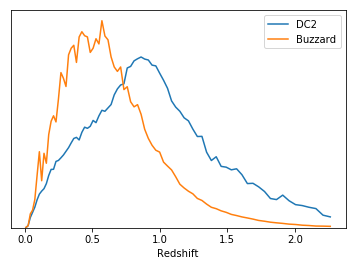

In [15]:
zc = 0.5 * (zds[1:] + zds[:-1])
plt.plot(zc, dndz_dc2, label='DC2')
plt.plot(zc, dndz_buz, label='Buzzard')
plt.xlabel('Redshift')
plt.yticks([])
plt.ylim(0, None)
plt.legend();

In [25]:
def optimize_direct(nbin, ntrial, nsteps, eta, transform, metric, method, seed, dndz_total=dndz_buz, init_data=init_data):
    mixing = jnp.diag(dndz_total)
    return optimize(
        nbin, mixing, init_data, ntrial=ntrial, interval=nsteps // 4,
        transform=transform, method=method, metric=metric,
        opt_args=dict(optimizer=optimizers.adam(eta), nsteps=nsteps))

In [27]:
def run_study(path, func, rerun=[]):
    path = Path(path)
    with open(path / 'config.yaml') as f:
        config = yaml.safe_load(f)
    nstudy = len(config['nbin'])
    argsiter = []
    argnames = config.keys()
    for arg in argnames:
        if not isinstance(config[arg], list):
            argsiter.append(itertools.repeat(config[arg]))
        elif len(config[arg]) != nstudy:
            print(f'Expected 1 or {nstudy} values for {arg}.')
            return
        else:
            argsiter.append(iter(config[arg]))
    for argvalues in zip(*argsiter):
        kw = dict(zip(argnames, argvalues))
        nbin = kw['nbin']
        outpath = path / f'nbin-{nbin}'
        if not outpath.exists():
            outpath.mkdir()          
        if (not rerun == 'all') and (nbin not in rerun) and (outpath / f'scores-{nbin}.yaml').exists():
            # Assume that this job has already run successfully.
            print(f'Skipping already completed job for nbin={nbin}')
            continue
        # Run the optimization for this nbin.
        print(f'Running job with {kw}')
        best_scores, dndz_bin, all_scores = func(**kw)
        # Save the results to outpath.
        np.savez(outpath / f'dndz-{nbin}.npz', dndz=dndz_bin, zedges=init_data[0])
        for scores in all_scores:
            plt.plot(scores, 'r-', alpha=0.3)
        plt.xlabel('Optimization step')
        plt.ylabel(kw.get('metric', 'Score'))
        plt.savefig(outpath / f'training-{nbin}.png')
        plt.show()
        plot_dndz(dndz_bin, init_data[0])
        plt.savefig(outpath / f'dndz-{nbin}.png')
        plt.show()
        with open(outpath / f'scores-{nbin}.yaml', 'w') as f:
            yaml.dump(best_scores, f)

Running job with {'nbin': 2, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=955.378 (max=955.378) after 375 steps.
  score=957.029 (max=957.029) after 750 steps.
  score=957.539 (max=957.539) after 1125 steps.
  score=957.742 (max=957.742) after 1500 steps.
trial 1/10: score=957.742 (max=957.742) after 1500 steps.
  score=955.202 (max=957.742) after 375 steps.
  score=956.868 (max=957.742) after 750 steps.
  score=957.369 (max=957.742) after 1125 steps.
  score=957.594 (max=957.742) after 1500 steps.
trial 2/10: score=957.594 (max=957.742) after 1500 steps.
  score=954.191 (max=957.742) after 375 steps.
  score=956.359 (max=957.742) after 750 steps.
  score=957.038 (max=957.742) after 1125 steps.
  score=957.350 (max=957.742) after 1500 steps.
trial 3/10: score=957.350 (max=957.742) after 1500 steps.
  score=955.291 (max=957.742) after 375 steps.
  score=957.353 (max=957.742) after 750 steps.
  score=958.043 

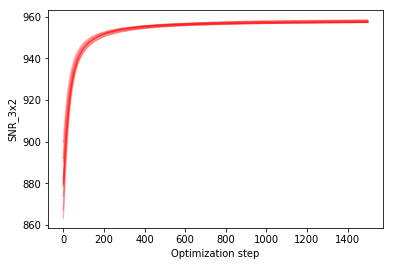

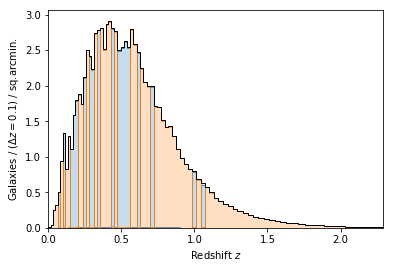

Running job with {'nbin': 4, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=1346.926 (max=1346.926) after 750 steps.
  score=1352.082 (max=1352.082) after 1500 steps.
  score=1353.684 (max=1353.684) after 2250 steps.
  score=1354.442 (max=1354.442) after 3000 steps.
trial 1/10: score=1354.442 (max=1354.442) after 3000 steps.
  score=1344.148 (max=1354.442) after 750 steps.
  score=1349.034 (max=1354.442) after 1500 steps.
  score=1350.328 (max=1354.442) after 2250 steps.
  score=1350.891 (max=1354.442) after 3000 steps.
trial 2/10: score=1350.891 (max=1354.442) after 3000 steps.
  score=1345.514 (max=1354.442) after 750 steps.
  score=1350.004 (max=1354.442) after 1500 steps.
  score=1351.198 (max=1354.442) after 2250 steps.
  score=1351.718 (max=1354.442) after 3000 steps.
trial 3/10: score=1351.718 (max=1354.442) after 3000 steps.
  score=1344.137 (max=1354.442) after 750 steps.
  score=1349.929 (max=1354.4

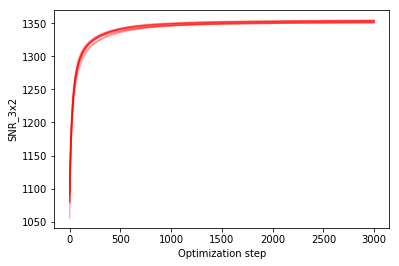

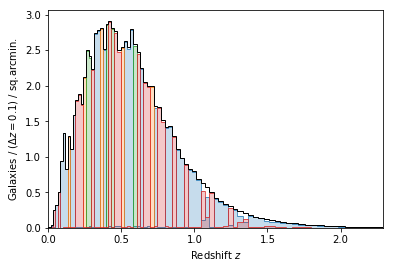

Running job with {'nbin': 6, 'ntrial': 10, 'nsteps': 4500, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=1645.812 (max=1645.812) after 1125 steps.
  score=1652.883 (max=1652.883) after 2250 steps.
  score=1654.487 (max=1654.487) after 3375 steps.
  score=1655.104 (max=1655.104) after 4500 steps.
trial 1/10: score=1655.104 (max=1655.104) after 4500 steps.
  score=1647.855 (max=1655.104) after 1125 steps.
  score=1655.254 (max=1655.254) after 2250 steps.
  score=1657.029 (max=1657.029) after 3375 steps.
  score=1657.660 (max=1657.660) after 4500 steps.
trial 2/10: score=1657.660 (max=1657.660) after 4500 steps.
  score=1649.409 (max=1657.660) after 1125 steps.
  score=1655.465 (max=1657.660) after 2250 steps.
  score=1657.036 (max=1657.660) after 3375 steps.
  score=1657.723 (max=1657.723) after 4500 steps.
trial 3/10: score=1657.723 (max=1657.723) after 4500 steps.
  score=1650.620 (max=1657.723) after 1125 steps.
  score=1657.722 (max=16

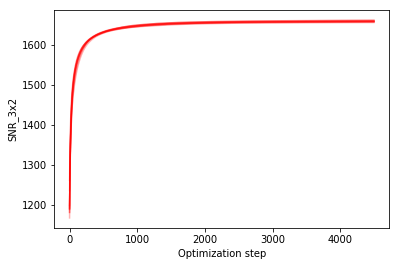

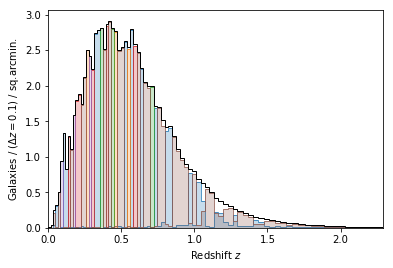

Running job with {'nbin': 8, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=1901.542 (max=1901.542) after 1500 steps.
  score=1908.733 (max=1908.733) after 3000 steps.
  score=1910.630 (max=1910.630) after 4500 steps.
  score=1911.375 (max=1911.375) after 6000 steps.
trial 1/10: score=1911.375 (max=1911.375) after 6000 steps.
  score=1905.131 (max=1911.375) after 1500 steps.
  score=1911.519 (max=1911.519) after 3000 steps.
  score=1913.373 (max=1913.373) after 4500 steps.
  score=1914.083 (max=1914.083) after 6000 steps.
trial 2/10: score=1914.083 (max=1914.083) after 6000 steps.
  score=1905.137 (max=1914.083) after 1500 steps.
  score=1913.101 (max=1914.083) after 3000 steps.
  score=1915.060 (max=1915.060) after 4500 steps.
  score=1915.775 (max=1915.775) after 6000 steps.
trial 3/10: score=1915.775 (max=1915.775) after 6000 steps.
  score=1908.236 (max=1915.775) after 1500 steps.
  score=1914.880 (max=19

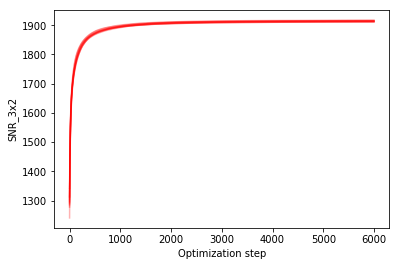

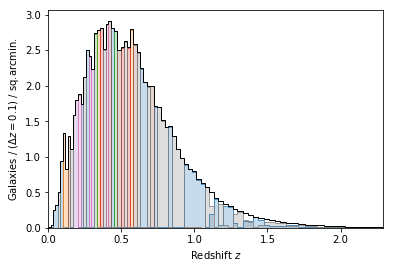

Running job with {'nbin': 10, 'ntrial': 10, 'nsteps': 7500, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=2130.203 (max=2130.203) after 1875 steps.
  score=2138.088 (max=2138.088) after 3750 steps.
  score=2140.043 (max=2140.043) after 5625 steps.
  score=2140.643 (max=2140.643) after 7500 steps.
trial 1/10: score=2140.643 (max=2140.643) after 7500 steps.
  score=2133.722 (max=2140.643) after 1875 steps.
  score=2140.645 (max=2140.645) after 3750 steps.
  score=2142.331 (max=2142.331) after 5625 steps.
  score=2142.973 (max=2142.974) after 7500 steps.
trial 2/10: score=2142.973 (max=2142.974) after 7500 steps.
  score=2130.392 (max=2142.974) after 1875 steps.
  score=2139.948 (max=2142.974) after 3750 steps.
  score=2141.925 (max=2142.974) after 5625 steps.
  score=2142.584 (max=2142.974) after 7500 steps.
trial 3/10: score=2142.584 (max=2142.974) after 7500 steps.
  score=2134.870 (max=2142.974) after 1875 steps.
  score=2144.475 (max=2

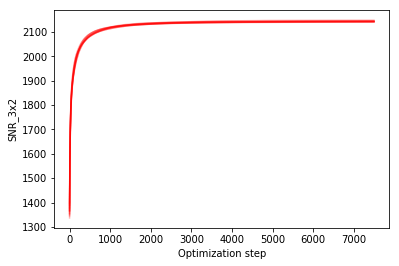

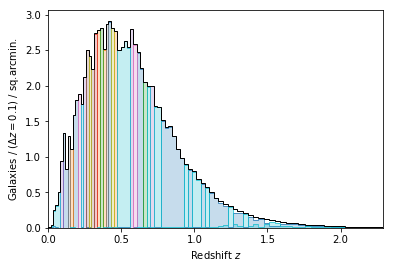

In [29]:
run_study('results/direct-snr', optimize_direct)

Running job with {'nbin': 2, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.1, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=806.440 (max=806.440) after 375 steps.
  score=862.701 (max=862.833) after 750 steps.
  score=863.135 (max=863.289) after 1125 steps.
  score=863.228 (max=863.413) after 1500 steps.
trial 1/10: score=863.228 (max=863.413) after 1500 steps.
  score=1369.219 (max=1369.219) after 375 steps.
  score=1372.716 (max=1372.825) after 750 steps.
  score=1373.239 (max=1373.373) after 1125 steps.
  score=1373.449 (max=1373.494) after 1500 steps.
trial 2/10: score=1373.449 (max=1373.494) after 1500 steps.
  score=1082.323 (max=1373.494) after 375 steps.
  score=1083.732 (max=1373.494) after 750 steps.
  score=1083.984 (max=1373.494) after 1125 steps.
  score=1084.249 (max=1373.494) after 1500 steps.
trial 3/10: score=1084.249 (max=1373.494) after 1500 steps.
  score=1404.424 (max=1404.424) after 375 steps.
  score=1406.828 (max=1406.850) after 750 

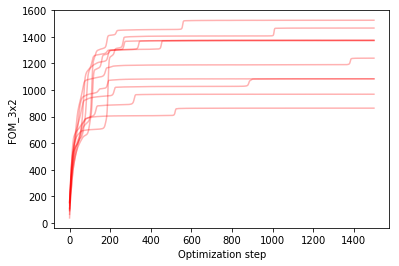

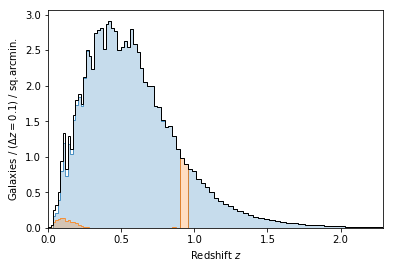

Running job with {'nbin': 4, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.1, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=4196.730 (max=4196.730) after 750 steps.
  score=4208.352 (max=4208.542) after 1500 steps.
  score=4212.370 (max=4212.370) after 2250 steps.
  score=4213.755 (max=4213.860) after 3000 steps.
trial 1/10: score=4213.755 (max=4213.860) after 3000 steps.
  score=2943.353 (max=4213.860) after 750 steps.
  score=3015.012 (max=4213.860) after 1500 steps.
  score=3020.687 (max=4213.860) after 2250 steps.
  score=3022.122 (max=4213.860) after 3000 steps.
trial 2/10: score=3022.122 (max=4213.860) after 3000 steps.
  score=3398.938 (max=4213.860) after 750 steps.
  score=3535.677 (max=4213.860) after 1500 steps.
  score=3537.083 (max=4213.860) after 2250 steps.
  score=3552.062 (max=4213.860) after 3000 steps.
trial 3/10: score=3552.062 (max=4213.860) after 3000 steps.
  score=4390.188 (max=4390.582) after 750 steps.
  score=4401.930 (max=4401.96

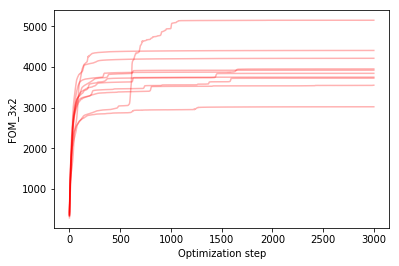

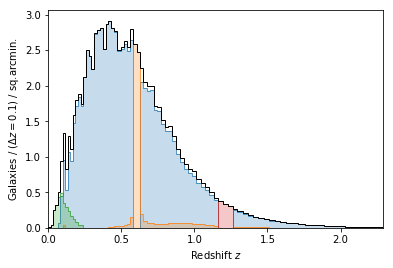

Running job with {'nbin': 6, 'ntrial': 10, 'nsteps': 4500, 'eta': 0.1, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=6117.903 (max=6121.206) after 1125 steps.
  score=6133.711 (max=6135.538) after 2250 steps.
  score=6139.951 (max=6141.189) after 3375 steps.
  score=6142.823 (max=6143.214) after 4500 steps.
trial 1/10: score=6142.823 (max=6143.214) after 4500 steps.
  score=5638.144 (max=6143.214) after 1125 steps.
  score=5659.508 (max=6143.214) after 2250 steps.
  score=5664.872 (max=6143.214) after 3375 steps.
  score=5666.871 (max=6143.214) after 4500 steps.
trial 2/10: score=5666.871 (max=6143.214) after 4500 steps.
  score=5115.425 (max=6143.214) after 1125 steps.
  score=5125.028 (max=6143.214) after 2250 steps.
  score=5128.246 (max=6143.214) after 3375 steps.
  score=5186.543 (max=6143.214) after 4500 steps.
trial 3/10: score=5186.543 (max=6143.214) after 4500 steps.
  score=5480.897 (max=6143.214) after 1125 steps.
  score=5491.989 (max=614

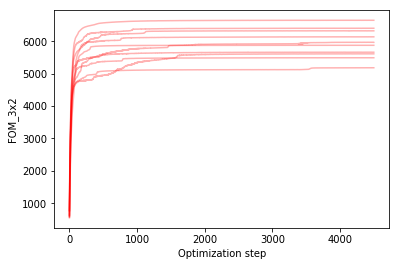

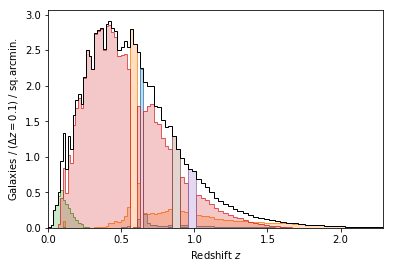

Running job with {'nbin': 8, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.1, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=8252.369 (max=8254.325) after 1500 steps.
  score=8305.799 (max=8307.739) after 3000 steps.
  score=8318.668 (max=8320.386) after 4500 steps.
  score=8324.377 (max=8325.323) after 6000 steps.
trial 1/10: score=8324.377 (max=8325.323) after 6000 steps.
  score=7200.022 (max=8325.323) after 1500 steps.
  score=7210.007 (max=8325.323) after 3000 steps.
  score=7213.054 (max=8325.323) after 4500 steps.
  score=7213.486 (max=8325.323) after 6000 steps.
trial 2/10: score=7213.486 (max=8325.323) after 6000 steps.
  score=7473.787 (max=8325.323) after 1500 steps.
  score=7499.862 (max=8325.323) after 3000 steps.
  score=7502.406 (max=8325.323) after 4500 steps.
  score=7502.763 (max=8325.323) after 6000 steps.
trial 3/10: score=7502.763 (max=8325.323) after 6000 steps.
  score=7671.620 (max=8325.323) after 1500 steps.
  score=7764.098 (max=832

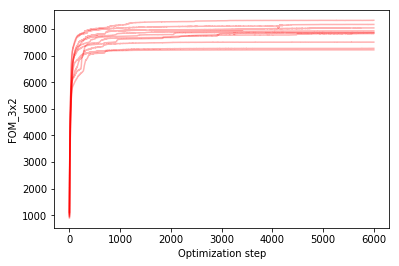

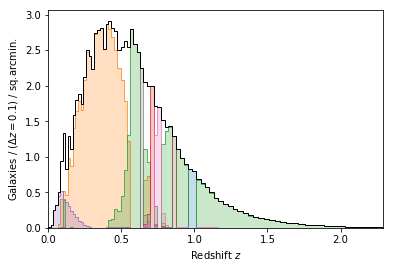

Running job with {'nbin': 10, 'ntrial': 10, 'nsteps': 7500, 'eta': 0.1, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=9133.171 (max=9135.754) after 1875 steps.
  score=9195.088 (max=9195.921) after 3750 steps.
  score=9258.403 (max=9258.403) after 5625 steps.
  score=9294.558 (max=9296.111) after 7500 steps.
trial 1/10: score=9294.558 (max=9296.111) after 7500 steps.
  score=8511.273 (max=9296.111) after 1875 steps.
  score=8562.951 (max=9296.111) after 3750 steps.
  score=8565.584 (max=9296.111) after 5625 steps.
  score=8566.770 (max=9296.111) after 7500 steps.
trial 2/10: score=8566.770 (max=9296.111) after 7500 steps.
  score=8806.664 (max=9296.111) after 1875 steps.
  score=8818.396 (max=9296.111) after 3750 steps.
  score=8822.781 (max=9296.111) after 5625 steps.
  score=8821.728 (max=9296.111) after 7500 steps.
trial 3/10: score=8821.728 (max=9296.111) after 7500 steps.
  score=8978.176 (max=9296.111) after 1875 steps.
  score=9201.920 (max=92

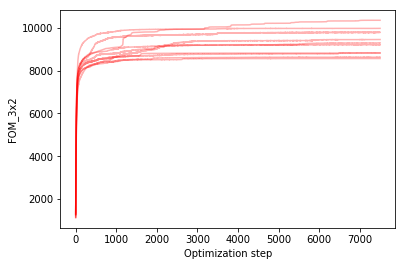

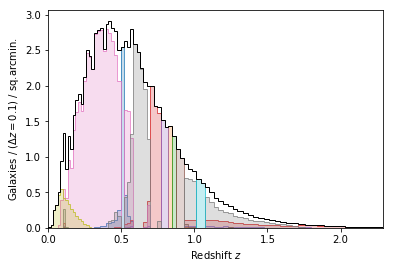

In [28]:
run_study('results/direct-fom', optimize_direct)

Running job with {'nbin': 2, 'ntrial': 10, 'nsteps': 1000, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=20.918 (max=20.918) after 250 steps.
  score=22.061 (max=22.061) after 500 steps.
  score=22.402 (max=22.402) after 750 steps.
  score=22.520 (max=22.521) after 1000 steps.
trial 1/10: score=22.520 (max=22.521) after 1000 steps.
  score=20.319 (max=22.521) after 250 steps.
  score=21.783 (max=22.521) after 500 steps.
  score=22.253 (max=22.521) after 750 steps.
  score=22.438 (max=22.521) after 1000 steps.
trial 2/10: score=22.438 (max=22.521) after 1000 steps.
  score=20.495 (max=22.521) after 250 steps.
  score=21.868 (max=22.521) after 500 steps.
  score=22.299 (max=22.521) after 750 steps.
  score=22.461 (max=22.521) after 1000 steps.
trial 3/10: score=22.461 (max=22.521) after 1000 steps.
  score=20.717 (max=22.521) after 250 steps.
  score=21.977 (max=22.521) after 500 steps.
  score=22.341 (max=22.521) after 750 steps.
  score=22.495 (

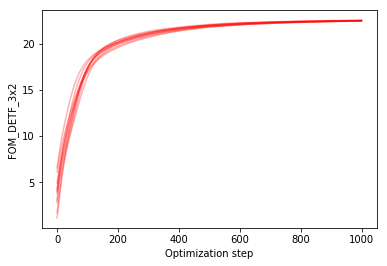

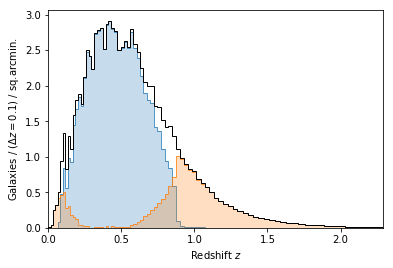

Running job with {'nbin': 4, 'ntrial': 10, 'nsteps': 2000, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=63.099 (max=63.099) after 500 steps.
  score=65.469 (max=65.481) after 1000 steps.
  score=66.134 (max=66.148) after 1500 steps.
  score=66.466 (max=66.474) after 2000 steps.
trial 1/10: score=66.466 (max=66.474) after 2000 steps.
  score=62.059 (max=66.474) after 500 steps.
  score=65.678 (max=66.474) after 1000 steps.
  score=66.659 (max=66.659) after 1500 steps.
  score=67.088 (max=67.091) after 2000 steps.
trial 2/10: score=67.088 (max=67.091) after 2000 steps.
  score=49.022 (max=67.091) after 500 steps.
  score=65.316 (max=67.091) after 1000 steps.
  score=66.622 (max=67.091) after 1500 steps.
  score=66.898 (max=67.091) after 2000 steps.
trial 3/10: score=66.898 (max=67.091) after 2000 steps.
  score=64.013 (max=67.091) after 500 steps.
  score=66.073 (max=67.091) after 1000 steps.
  score=66.664 (max=67.091) after 1500 steps.
  score=

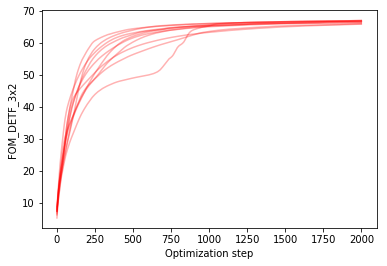

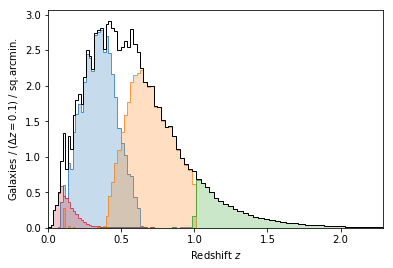

Running job with {'nbin': 6, 'ntrial': 10, 'nsteps': 3000, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=84.664 (max=84.664) after 750 steps.
  score=86.687 (max=86.713) after 1500 steps.
  score=87.530 (max=87.550) after 2250 steps.
  score=87.957 (max=87.963) after 3000 steps.
trial 1/10: score=87.957 (max=87.963) after 3000 steps.
  score=81.241 (max=87.963) after 750 steps.
  score=84.082 (max=87.963) after 1500 steps.
  score=85.000 (max=87.963) after 2250 steps.
  score=85.487 (max=87.963) after 3000 steps.
trial 2/10: score=85.487 (max=87.963) after 3000 steps.
  score=80.212 (max=87.963) after 750 steps.
  score=83.715 (max=87.963) after 1500 steps.
  score=85.108 (max=87.963) after 2250 steps.
  score=85.754 (max=87.963) after 3000 steps.
trial 3/10: score=85.754 (max=87.963) after 3000 steps.
  score=83.268 (max=87.963) after 750 steps.
  score=86.281 (max=87.963) after 1500 steps.
  score=87.456 (max=87.963) after 2250 steps.
  score=

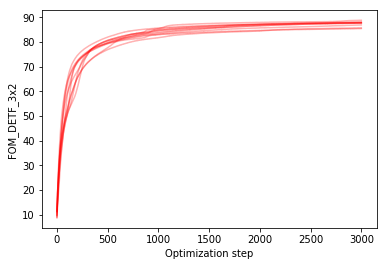

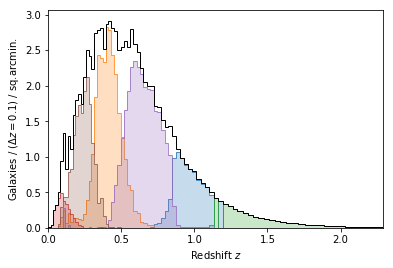

Running job with {'nbin': 8, 'ntrial': 10, 'nsteps': 4000, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=97.727 (max=97.765) after 1000 steps.
  score=103.029 (max=103.062) after 2000 steps.
  score=104.074 (max=104.074) after 3000 steps.
  score=104.835 (max=104.858) after 4000 steps.
trial 1/10: score=104.835 (max=104.858) after 4000 steps.
  score=96.247 (max=104.858) after 1000 steps.
  score=100.355 (max=104.858) after 2000 steps.
  score=102.420 (max=104.858) after 3000 steps.
  score=103.161 (max=104.858) after 4000 steps.
trial 2/10: score=103.161 (max=104.858) after 4000 steps.
  score=93.226 (max=104.858) after 1000 steps.
  score=98.151 (max=104.858) after 2000 steps.
  score=100.458 (max=104.858) after 3000 steps.
  score=102.285 (max=104.858) after 4000 steps.
trial 3/10: score=102.285 (max=104.858) after 4000 steps.
  score=95.660 (max=104.858) after 1000 steps.
  score=99.745 (max=104.858) after 2000 steps.
  score=101.735 (max=10

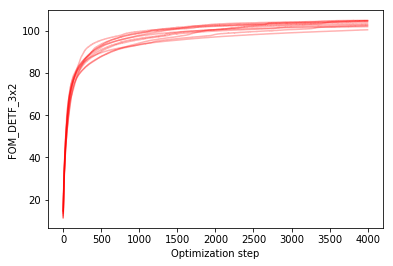

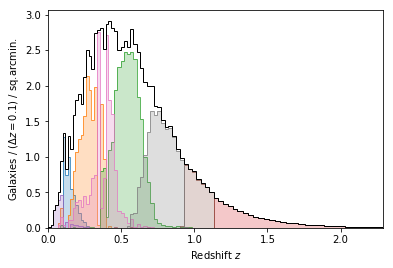

Running job with {'nbin': 10, 'ntrial': 10, 'nsteps': 5000, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=109.943 (max=109.943) after 1250 steps.
  score=116.768 (max=116.769) after 2500 steps.
  score=119.791 (max=119.804) after 3750 steps.
  score=121.621 (max=121.629) after 5000 steps.
trial 1/10: score=121.621 (max=121.629) after 5000 steps.
  score=112.180 (max=121.629) after 1250 steps.
  score=115.792 (max=121.629) after 2500 steps.
  score=118.124 (max=121.629) after 3750 steps.
  score=119.421 (max=121.629) after 5000 steps.
trial 2/10: score=119.421 (max=121.629) after 5000 steps.
  score=111.035 (max=121.629) after 1250 steps.
  score=115.830 (max=121.629) after 2500 steps.
  score=117.339 (max=121.629) after 3750 steps.
  score=118.810 (max=121.629) after 5000 steps.
trial 3/10: score=118.810 (max=121.629) after 5000 steps.
  score=111.987 (max=121.629) after 1250 steps.
  score=117.426 (max=121.629) after 2500 steps.
  score=119.242

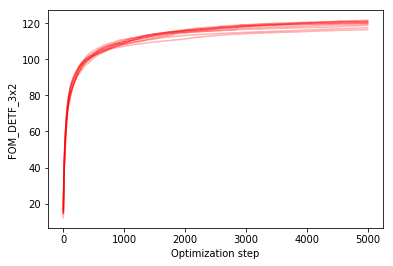

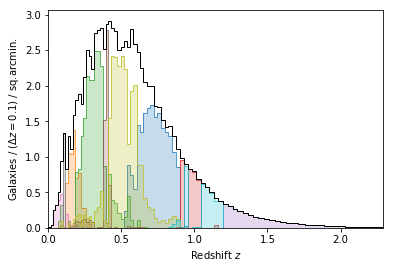

In [21]:
run_study('results/direct-detf', optimize_direct)

## Optimize redshift bins using features

In [18]:
def optimize_bins(nbin, zhist, ntrial=10, nsteps=500, init_data=init_data):
    
    ngrp, nzin = zhist.shape
    nzout = len(init_data[0]) - 1
    assert nzin % nzout == 0
    downsampling = nzin // nzout
    if downsampling > 1:
        print(f'Downsampling by {downsampling}.')
        zhist = zhist.reshape(ngrp, nzout, downsampling).sum(axis=-1)
    mixing = jnp.array(zhist / zhist.sum())
    
    scores, dndz_bin = optimize(
        nbin, mixing, init_data, ntrial=ntrial, interval=nsteps // 4,
        transform='extend',
        opt_args=dict(optimizer=optimizers.adam(0.02), nsteps=nsteps))
    print(scores)
    plot_dndz(dndz_bin, init_data[0])
    return scores, dndz_bin

  score=45.999 (max=45.999) after 500 steps.
  score=50.090 (max=50.090) after 1000 steps.
  score=51.831 (max=51.831) after 1500 steps.
  score=52.725 (max=52.725) after 2000 steps.
trial 1/10: score=52.725 (max=52.725) after 2000 steps.
  score=49.505 (max=52.725) after 500 steps.
  score=54.345 (max=54.345) after 1000 steps.
  score=55.775 (max=55.775) after 1500 steps.
  score=56.067 (max=56.070) after 2000 steps.
trial 2/10: score=56.067 (max=56.070) after 2000 steps.
  score=49.272 (max=56.070) after 500 steps.
  score=51.242 (max=56.070) after 1000 steps.
  score=52.261 (max=56.070) after 1500 steps.
  score=52.879 (max=56.070) after 2000 steps.
trial 3/10: score=52.879 (max=56.070) after 2000 steps.
  score=52.325 (max=56.070) after 500 steps.
  score=54.095 (max=56.070) after 1000 steps.
  score=54.792 (max=56.070) after 1500 steps.
  score=55.146 (max=56.070) after 2000 steps.
trial 4/10: score=55.146 (max=56.070) after 2000 steps.
  score=52.249 (max=56.070) after 500 steps.

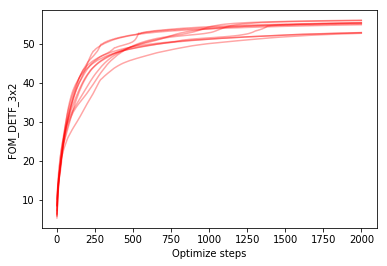

{'FOM_3x2': 2375.6484375, 'FOM_DETF_3x2': 56.069576263427734, 'SNR_3x2': 1193.0482177734375}
CPU times: user 2min 44s, sys: 5.02 s, total: 2min 49s
Wall time: 2min 42s


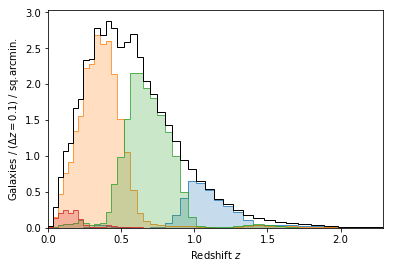

In [13]:
%time results = optimize_bins(4, zhist_emd, nsteps=2000)

1.0
  score=49.749 (max=49.749) after 500 steps.
  score=53.694 (max=53.699) after 1000 steps.
  score=54.596 (max=54.596) after 1500 steps.
  score=55.005 (max=55.005) after 2000 steps.
trial 1/10: score=55.005 (max=55.005) after 2000 steps.
  score=49.963 (max=55.005) after 500 steps.
  score=53.608 (max=55.005) after 1000 steps.
  score=55.426 (max=55.426) after 1500 steps.
  score=55.746 (max=55.747) after 2000 steps.
trial 2/10: score=55.746 (max=55.747) after 2000 steps.
  score=52.084 (max=55.747) after 500 steps.
  score=53.551 (max=55.747) after 1000 steps.
  score=54.216 (max=55.747) after 1500 steps.
  score=54.690 (max=55.747) after 2000 steps.
trial 3/10: score=54.690 (max=55.747) after 2000 steps.
  score=48.641 (max=55.747) after 500 steps.
  score=51.634 (max=55.747) after 1000 steps.
  score=54.227 (max=55.747) after 1500 steps.
  score=54.947 (max=55.747) after 2000 steps.
trial 4/10: score=54.947 (max=55.747) after 2000 steps.
  score=50.615 (max=55.747) after 500 st

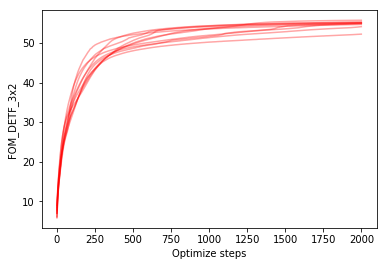

{'FOM_3x2': 2433.737060546875, 'FOM_DETF_3x2': 55.74658203125, 'SNR_3x2': 1201.71728515625}
CPU times: user 2min 41s, sys: 3.73 s, total: 2min 44s
Wall time: 2min 34s


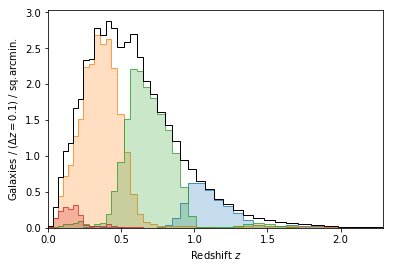

In [19]:
%time results = optimize_bins(4, zhist_emd_nofsim, nsteps=2000)

1.0
  score=49.615 (max=49.615) after 500 steps.
  score=53.189 (max=53.189) after 1000 steps.
  score=53.961 (max=53.961) after 1500 steps.
  score=54.183 (max=54.184) after 2000 steps.
trial 1/10: score=54.183 (max=54.184) after 2000 steps.
  score=47.503 (max=54.184) after 500 steps.
  score=49.794 (max=54.184) after 1000 steps.
  score=51.503 (max=54.184) after 1500 steps.
  score=52.075 (max=54.184) after 2000 steps.
trial 2/10: score=52.075 (max=54.184) after 2000 steps.
  score=47.508 (max=54.184) after 500 steps.
  score=50.017 (max=54.184) after 1000 steps.
  score=51.622 (max=54.184) after 1500 steps.
  score=52.221 (max=54.184) after 2000 steps.
trial 3/10: score=52.221 (max=54.184) after 2000 steps.
  score=49.610 (max=54.184) after 500 steps.
  score=52.771 (max=54.184) after 1000 steps.
  score=53.469 (max=54.184) after 1500 steps.
  score=53.749 (max=54.184) after 2000 steps.
trial 4/10: score=53.749 (max=54.184) after 2000 steps.
  score=51.664 (max=54.184) after 500 st

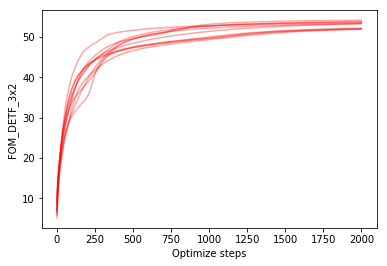

{'FOM_3x2': 2302.162353515625, 'FOM_DETF_3x2': 54.18437957763672, 'SNR_3x2': 1196.576416015625}
CPU times: user 2min 41s, sys: 3.46 s, total: 2min 45s
Wall time: 2min 35s


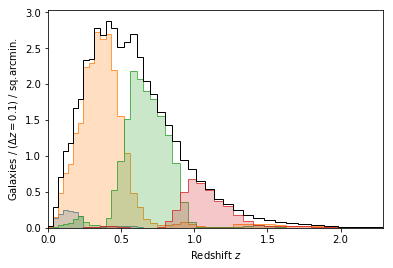

In [20]:
%time results = optimize_bins(4, zhist_wgt, nsteps=2000)

1.0
  score=50.854 (max=50.854) after 500 steps.
  score=54.267 (max=54.267) after 1000 steps.
  score=55.299 (max=55.299) after 1500 steps.
  score=55.730 (max=55.730) after 2000 steps.
trial 1/10: score=55.730 (max=55.730) after 2000 steps.
  score=51.443 (max=55.730) after 500 steps.
  score=53.906 (max=55.730) after 1000 steps.
  score=54.794 (max=55.730) after 1500 steps.
  score=55.262 (max=55.730) after 2000 steps.
trial 2/10: score=55.262 (max=55.730) after 2000 steps.
  score=46.007 (max=55.730) after 500 steps.
  score=51.397 (max=55.730) after 1000 steps.
  score=52.557 (max=55.730) after 1500 steps.
  score=55.440 (max=55.730) after 2000 steps.
trial 3/10: score=55.440 (max=55.730) after 2000 steps.
  score=50.407 (max=55.730) after 500 steps.
  score=53.614 (max=55.730) after 1000 steps.
  score=54.894 (max=55.730) after 1500 steps.
  score=55.479 (max=55.730) after 2000 steps.
trial 4/10: score=55.479 (max=55.730) after 2000 steps.
  score=50.760 (max=55.730) after 500 st

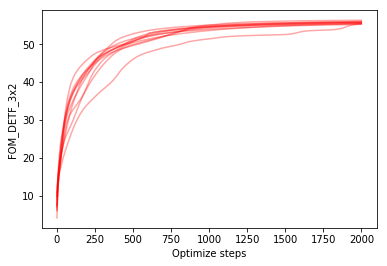

{'FOM_3x2': 2560.98828125, 'FOM_DETF_3x2': 56.32379913330078, 'SNR_3x2': 1192.5596923828125}
CPU times: user 2min 42s, sys: 3.67 s, total: 2min 45s
Wall time: 2min 35s


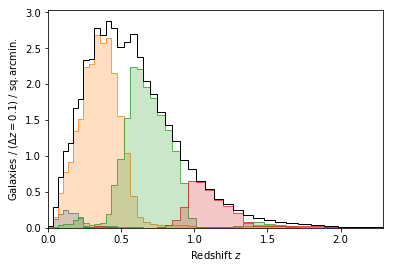

In [21]:
%time results = optimize_bins(4, zhist_cosine, nsteps=2000)

## Sandbox

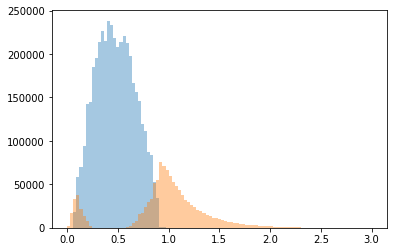

In [76]:
labels2 = get_labels(zbuz, wbest2)
plot_labels(zbuz, labels2)
np.save('buzzard_labels2.npy', labels2.astype(np.uint8))

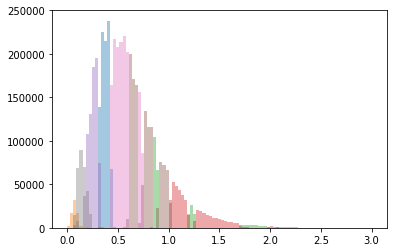

In [74]:
labels8 = get_labels(zbuz, wbest8)
plot_labels(zbuz, labels8)
np.save('buzzard_labels8.npy', labels8.astype(np.uint8))

Optimize weights using feature space groups:

In [186]:
def optimize_bins(zhist, nbin=2, ntrial=5, niter=100, eta=1., gamma=0.1, decay=1.0):

    ngrp, nzbin = zhist.shape
    nds = len(init_data[0]) - 1
    assert nzbin % nds == 0
    downsampling = nzbin // nds
    mixing = jnp.array(zhist.reshape((ngrp, nds, downsampling)).sum(axis=2))
    mixing /= mixing.sum()
    
    @jax.jit
    def get_weights(p):
        w = jnp.exp(p)
        return jnp.dot(w / w.sum(axis=0), mixing)
    
    return train((nbin, ngrp), get_weights, ntrial, niter, eta, gamma, decay)

In [239]:
def optimize_bins_new(zhist, nbin=2, ntrial=5, niter=100, eta=1., gamma=0.1, decay=1.0):

    ngrp, nzbin = zhist.shape
    nds = len(init_data[0]) - 1
    assert nzbin % nds == 0
    downsampling = nzbin // nds
    mixing = jnp.array(zhist.reshape((ngrp, nds, downsampling)).sum(axis=2))
    mixing /= mixing.sum()
    
    @jax.jit
    def get_weights(p):
        return jnp.dot(normalized_columns(p), mixing)
     
    return train((nbin - 1, ngrp), get_weights, ntrial, niter, eta, gamma, decay)

In [17]:
def load_tree(name):
    with np.load(name, allow_pickle=True) as keys:
        return keys['zedges'], keys['zhist'], keys['grpid']

In [18]:
zedgesT, zhistT, grpidT = load_tree('tree.npz')

0 7.926904678344727
50 18.992572784423828
100 19.57083511352539
150 19.870691299438477
200 20.060819625854492
250 20.149843215942383
300 20.209636688232422
350 20.292253494262695
400 20.352537155151367
450 20.387746810913086
Max score: 20.415.


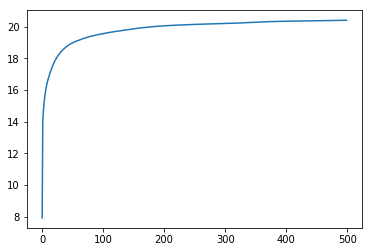

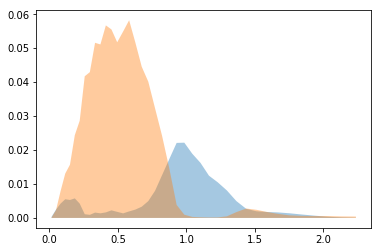

In [149]:
optimize_bins(zhistw, 2, eta=2, niter=500);

Assign bin labels to a sample based on optimized weights:

In [67]:
def get_labels(z, w, seed=1):
    nds = len(zds) - 1
    gen = np.random.RandomState(seed)
    # Assign each redshift to an input redshift bin.
    idx = np.clip(np.digitize(z, zds) - 1, 0, nds - 1)
    # Calculate the CDF for mapping each input bin to output bins.
    cdf = np.cumsum(w, axis=0)
    cdf /= cdf[-1]
    # Loop over input bins to assign output bins sampled from the CDF.
    labels = np.empty(len(z), int)
    for i in range(nds):
        sel = idx == i
        nsel = np.count_nonzero(sel)
        u = gen.uniform(size=nsel)
        labels[sel] = np.searchsorted(cdf[:, i], u)
    return labels
    
labels4 = get_labels(zbuz, wbest4)

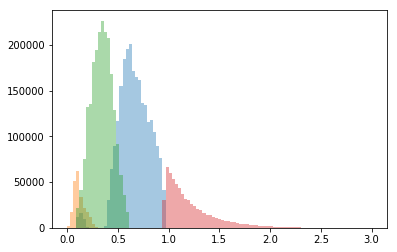

In [68]:
def plot_labels(z, labels):
    nbin = labels.max() + 1
    for i in range(nbin):
        sel = labels == i
        plt.hist(z[sel], bins=np.linspace(0, 3, 100), histtype='stepfilled', alpha=0.4)
        
plot_labels(zbuz, labels4)

In [69]:
np.save('buzzard_labels4.npy', labels4.astype(np.uint8))

In [70]:
ls -lh *.npy

-rw-rw-r-- 1 dkirkby dkirkby 5.2M Sep  3 07:41 buzzard_labels4.npy
-rw-rw-r-- 1 dkirkby dkirkby 8.3M Sep  2 11:50 dc2-labels.npy


## Nbins = 2

0 7.3986687660217285
50 18.784330368041992
100 19.653308868408203
150 19.987346649169922
200 20.19344711303711
250 20.293758392333984
300 20.33831024169922
350 20.36216926574707
400 20.381399154663086
450 20.39472007751465


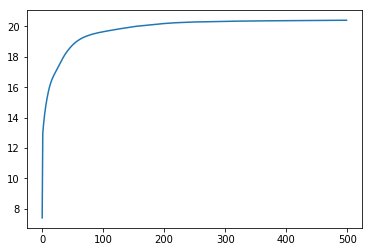

Max score: 20.409.


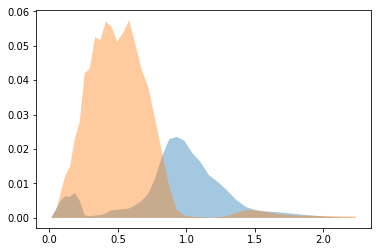

In [118]:
optimize_bins(zhistn, 2, eta=1., niter=500);

0 11.72891616821289
50 53.566261291503906
100 56.76713562011719
150 57.63714599609375
200 58.1176872253418
250 58.437564849853516
300 59.57559585571289
350 59.99556350708008
400 60.24839401245117
450 60.62715530395508


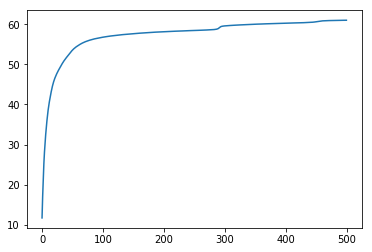

Max score: 60.984.


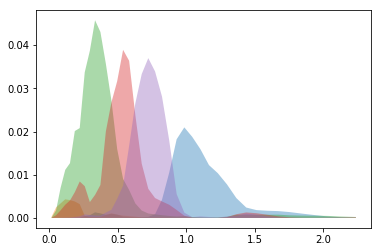

In [120]:
optimize_bins(zhistw, nbin=5, eta=1., niter=500);

0 11.476663589477539
50 46.96494674682617
100 50.201290130615234
150 51.214111328125
200 51.70956802368164
250 52.00373077392578
300 52.21335220336914
350 53.21934127807617
400 53.52640151977539
450 53.7055549621582
500 53.82396697998047
550 53.910335540771484
600 53.97649002075195
650 54.03995132446289
700 54.08826446533203
750 54.12969970703125
800 54.162689208984375
850 54.215980529785156
900 54.31020736694336
950 54.34477615356445


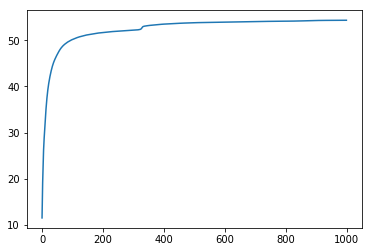

Max score: 54.367.


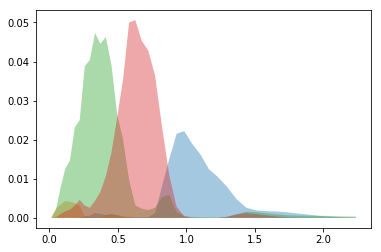

In [122]:
optimize_bins(zhistw, nbin=4, eta=1., niter=1000);

0 12.75029468536377
50 56.79963684082031
100 62.852474212646484
150 69.93870544433594
200 71.03986358642578
250 71.5235595703125
300 71.83009338378906
350 72.0654296875
400 72.30609130859375
450 72.47432708740234
500 72.61727142333984
550 72.8478012084961
600 73.02984619140625
650 73.1159439086914
700 73.19467163085938
750 73.32044219970703
800 73.48956298828125
850 73.55175018310547
900 73.58354949951172
950 73.61466217041016
1000 73.64636993408203
1050 73.80606079101562
1100 73.86512756347656
1150 73.89683532714844
1200 73.91090393066406
1250 73.92639923095703
1300 73.9473876953125
1350 73.96749114990234
1400 73.97801208496094
1450 73.99661254882812
1500 74.01612091064453
1550 74.01787567138672
1600 74.02864074707031
1650 74.03841400146484
1700 74.05205535888672
1750 74.05503845214844
1800 74.05911254882812
1850 74.064697265625
1900 74.07462310791016
1950 74.07882690429688


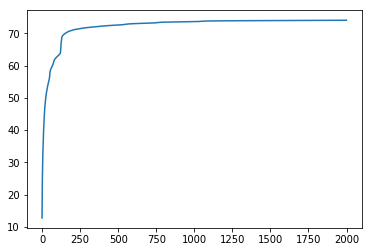

Max score: 74.091.


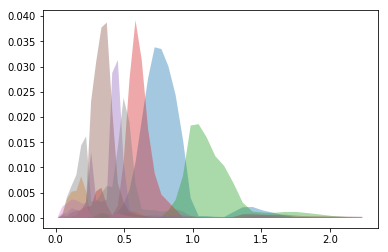

In [123]:
optimize_bins(zhistw, nbin=8, eta=1., niter=2000);

## Direct Optimization of the True Reshift Binning

In [87]:
np.save('dc2-labels.npy', labels.astype(np.uint8))

In [88]:
!ls -lh dc2-labels.npy

-rw-rw-r-- 1 dkirkby dkirkby 8.3M Sep  2 11:50 dc2-labels.npy


0 2.856764793395996
50 38.481788635253906


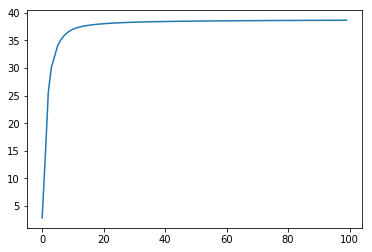

Max score: 38.635.


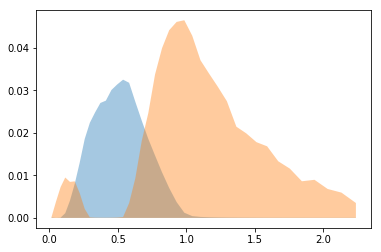

In [105]:
optimize_truez(dndz_dc2, nbin=2, eta=1., niter=100);

0 3.2000186443328857
50 21.976913452148438


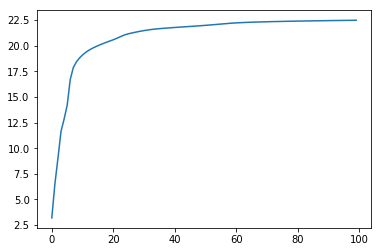

Max score: 22.474.


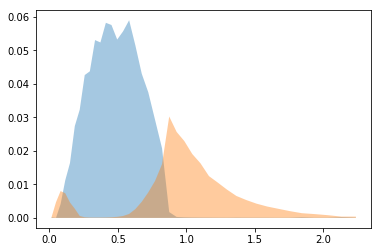

In [57]:
optimize_weights(dndz_buz, nbin=2, eta=1., niter=100);

0 3.2018086910247803
50 21.977750778198242


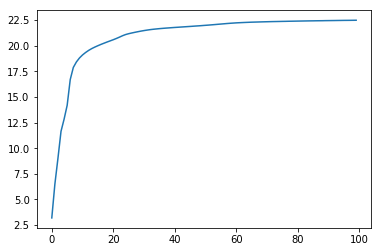

Max score: 22.472.
CPU times: user 3.55 s, sys: 135 ms, total: 3.69 s
Wall time: 3.58 s


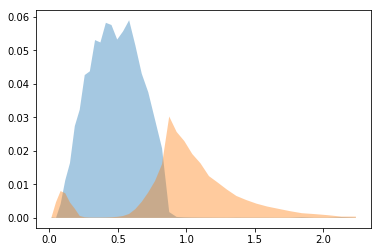

In [28]:
%time w2, m2 = optimize_weights(nbin=2, eta=1., niter=100)

0 6.0063157081604
50 45.33053207397461


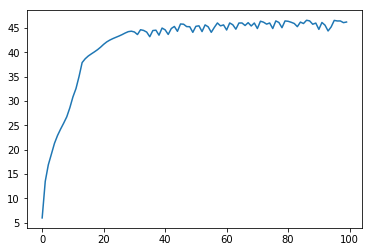

Max score: 46.574.
CPU times: user 7.89 s, sys: 71 ms, total: 7.97 s
Wall time: 7.84 s


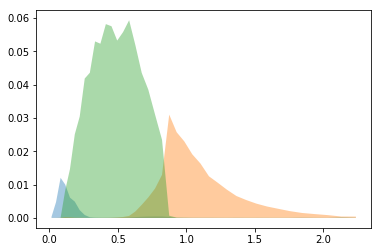

In [29]:
%time w3, m3 = optimize_weights(nbin=3, eta=1., niter=100)

0 8.490499496459961
50 58.03609085083008
100 62.18034744262695
150 62.82968521118164
200 63.00864028930664
250 63.640865325927734
300 65.184814453125
350 64.04039001464844
400 65.45266723632812
450 65.64655303955078


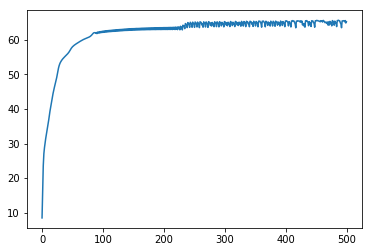

Max score: 65.698.
CPU times: user 1min 17s, sys: 149 ms, total: 1min 17s
Wall time: 1min 17s


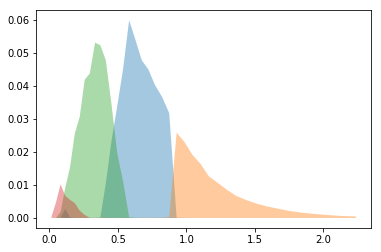

In [32]:
%time w4, m4 = optimize_weights(nbin=4, eta=0.5, niter=500)

0 9.764266967773438
50 62.84239959716797
100 70.74346923828125
150 73.1115493774414
200 72.82343292236328
250 74.05504608154297
300 73.94087982177734
350 74.84740447998047
400 75.19644165039062
450 75.52391052246094


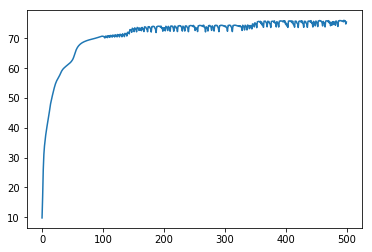

Max score: 76.101.
CPU times: user 2min 56s, sys: 518 ms, total: 2min 57s
Wall time: 2min 57s


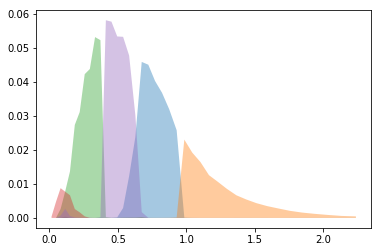

In [33]:
%time w5, m5 = optimize_weights(nbin=5, eta=0.5, niter=500)

0 13.888534545898438
50 68.62844848632812
100 75.19667053222656
150 76.26265716552734
200 77.2719497680664
250 78.62643432617188
300 77.6267318725586
350 79.51612091064453
400 79.62677764892578
450 77.9648208618164


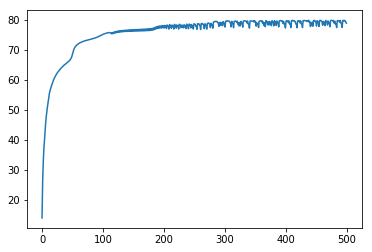

Max score: 79.900.
CPU times: user 5min 49s, sys: 970 ms, total: 5min 50s
Wall time: 5min 50s


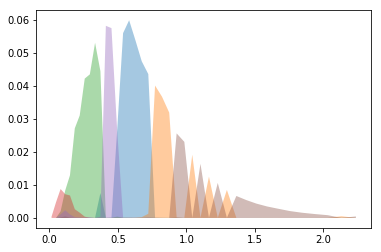

In [34]:
%time w6, m6 = optimize_weights(nbin=6, eta=0.5, niter=500)

0 54.26852035522461
50 75.6591567993164
100 78.65259552001953
150 79.76007080078125


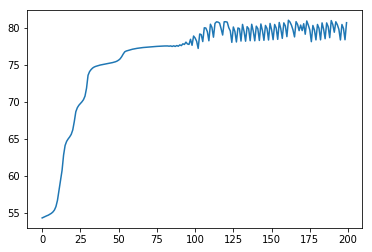

CPU times: user 2min 18s, sys: 616 ms, total: 2min 19s
Wall time: 2min 19s


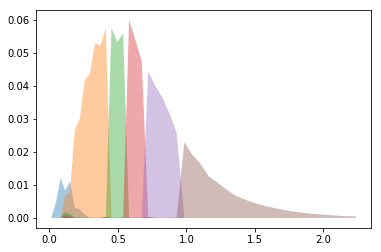

In [88]:
%time w6, m6 = method2_optimize(nbin=6, eta=0.7, niter=200)

0 16.436464309692383
50 84.64531707763672
100 86.92375183105469
150 88.50049591064453
200 88.01998138427734
250 88.68807983398438


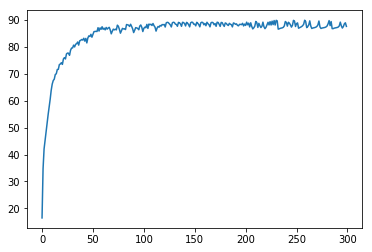

Max score: 89.942.
CPU times: user 6min 28s, sys: 1.22 s, total: 6min 29s
Wall time: 6min 29s


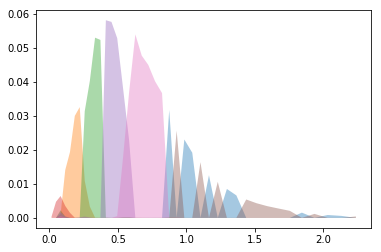

In [35]:
%time w7, m7 = optimize_weights(nbin=7, eta=1., niter=300)

0 25.680673599243164
50 144.82473754882812
100 145.5882110595703
150 147.18321228027344


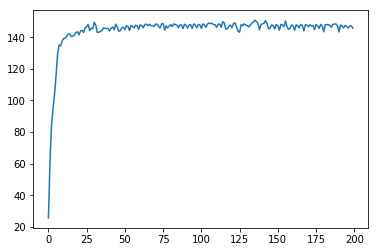

Max score: 150.726.
CPU times: user 6min 59s, sys: 627 ms, total: 6min 59s
Wall time: 6min 59s


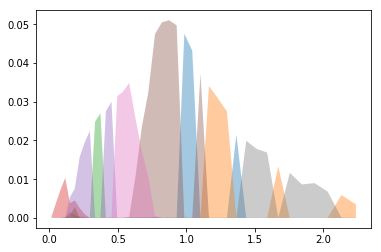

In [91]:
%time w8dc2, m8dc2 = optimize_weights(dndz_dc2, nbin=8, eta=1., niter=200)

0 22.10607147216797
50 89.36427307128906
100 96.18096923828125
150 99.5829086303711


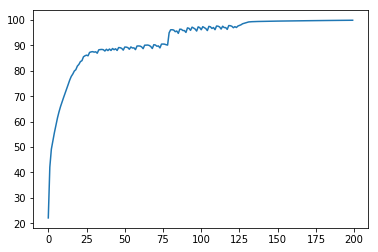

Max score: 99.917.
CPU times: user 6min 57s, sys: 866 ms, total: 6min 58s
Wall time: 6min 58s


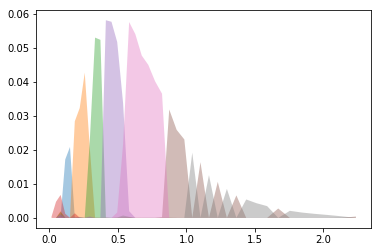

In [36]:
%time w8, m8 = optimize_weights(nbin=8, eta=1., niter=200)

0 24.794164657592773
50 94.96270751953125
100 96.4365005493164
150 96.34480285644531


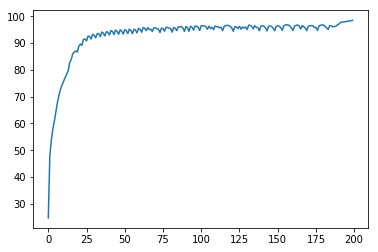

Max score: 98.481.
CPU times: user 10min 56s, sys: 1.28 s, total: 10min 57s
Wall time: 10min 57s


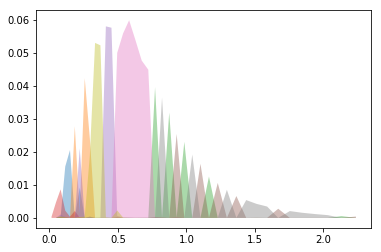

In [37]:
%time w9, m9 = optimize_weights(nbin=9, eta=1., niter=200)